<a href="https://colab.research.google.com/github/Alister03USA/Portfolio-and-Projects/blob/main/Image_Classification_using_CNNs_and_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd



Function to load the training and testing data from a Google Drive Path

In [ ]:
# Set the path to your dataset in Google Drive
base_dir = '/content/drive/MyDrive/Image Classifier (Elephants)'

# Load the data
train_gen, test_gen = data_loader(base_dir)

NameError: name 'data_loader' is not defined

Understand the Data

In [ ]:
train_path = '/content/drive/MyDrive/Image Classifier (Elephants)/train'
test_path = '/content/drive/MyDrive/Image Classifier (Elephants)/test'


filenames = [f for f in os.listdir(test_path) if f.lower().endswith(('.jpg', '.png'))]

data = []
for fname in filenames:
    label = 'African' if 'african' in fname.lower() else 'Asian'
    data.append({'Filename': fname, 'Labels': label})

df_test = pd.DataFrame(data)
# Define class directories
train_african_dir = os.path.join(train_path, 'African')
train_asian_dir = os.path.join(train_path, 'Asian')

test_african_dir = os.path.join(test_path, 'African')
test_asian_dir = os.path.join(test_path, 'Asian')

# Count images in each class
num_african_tr = len(os.listdir(train_african_dir))
num_asian_tr = len(os.listdir(train_asian_dir))

num_african_val = len(os.listdir(test_african_dir))
num_asian_val = len(os.listdir(test_asian_dir))

# Calculate totals
total_train = num_african_tr + num_asian_tr
total_val = num_african_val + num_asian_val

# Print information
print('Total training African elephant images:', num_african_tr)
print('Total training Asian elephant images:', num_asian_tr)
print('Total validation African elephant images:', num_african_val)
print('Total validation Asian elephant images:', num_asian_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

Total training African elephant images: 420
Total training Asian elephant images: 420
Total validation African elephant images: 97
Total validation Asian elephant images: 91
--
Total training images: 840
Total validation images: 188


In [ ]:
# TEST

IMG_HEIGHT, IMG_WIDTH = 299, 299  # Xception expects 299x299 images
BATCH_SIZE = 32
EPOCHS = 20


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)

train_data_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_data_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


def build_model():
    base_model = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    base_model.trainable = False  # Freeze the base model

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


def trainer(model, train_data_gen, val_data_gen, epochs=EPOCHS):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        train_data_gen,
        validation_data=val_data_gen,
        epochs=epochs,
        callbacks=[early_stopping]
    )
    return history


def visualize_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()





Found 672 images belonging to 2 classes.
Found 168 images belonging to 2 classes.
Found 188 images belonging to 2 classes.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(model, val_data_gen):
    # Reset generator to start from beginning
    val_data_gen.reset()

    # Predict probabilities
    Y_pred = model.predict(val_data_gen)
    y_pred = (Y_pred > 0.5).astype(int).reshape(-1)

    # Get ground truth
    y_true = val_data_gen.classes

    # Ensure consistent class label names
    class_labels = list(val_data_gen.class_indices.keys())

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Print accuracy explicitly
    acc = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {acc:.2f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
model = build_model()
history = trainer(model, train_data_gen, val_data_gen, epochs=EPOCHS)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 299, 299, 3))
  warnings.warn(msg)


21/21 ━━━━━━━━━━━━━━━━━━━━ 193s 8s/step - accuracy: 0.5581 - loss: 0.7127 - val_accuracy: 0.5060 - val_loss: 0.6955
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5167 - loss: 0.7030 - val_accuracy: 0.5476 - val_loss: 0.6782
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5805 - loss: 0.6828 - val_accuracy: 0.6250 - val_loss: 0.6718
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5708 - loss: 0.6804 - val_accuracy: 0.6726 - val_loss: 0.6648
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5972 - loss: 0.6635 - val_accuracy: 0.6548 - val_loss: 0.6637
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6286 - loss: 0.6558 - val_accuracy: 0.6548 - val_loss: 0.6592
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6368 - loss: 0.6464 - val_accuracy: 0.6488 - val_loss: 0.6514
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6863 - loss: 0.6261 - val_accuracy: 0.6786 - val_loss: 0.6497
Ep

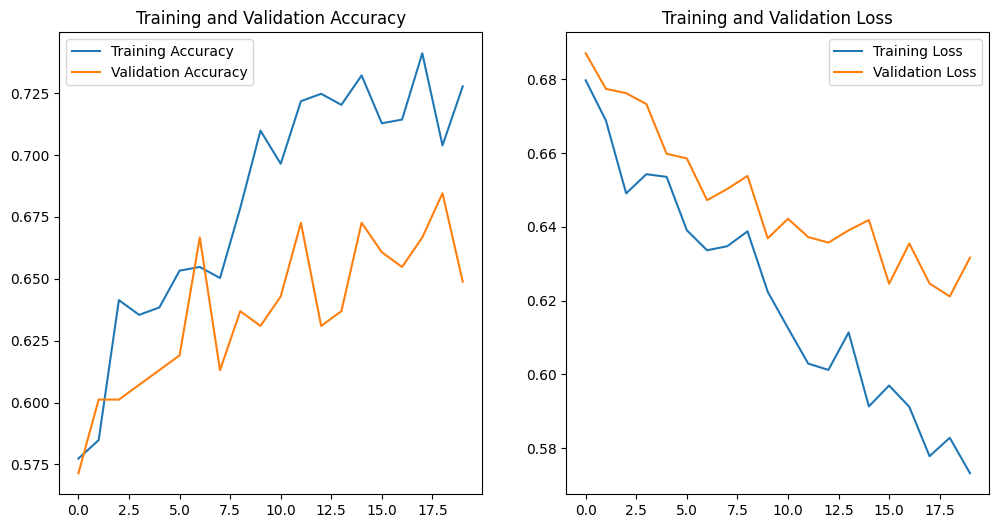

In [ ]:
visualize_training(history)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 52s 10s/step
Classification Report:

              precision    recall  f1-score   support

     African       0.83      0.94      0.88        97
       Asian       0.92      0.79      0.85        91

    accuracy                           0.87       188
   macro avg       0.88      0.86      0.87       188
weighted avg       0.87      0.87      0.87       188

Overall Accuracy: 0.87


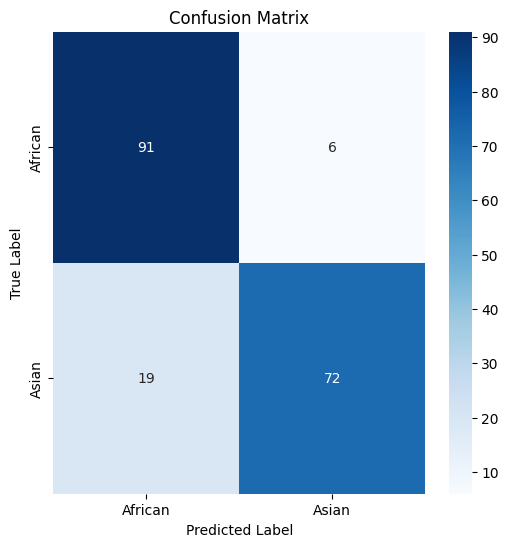

In [ ]:
evaluate_model(model, test_data_gen)

Visualize Training Images

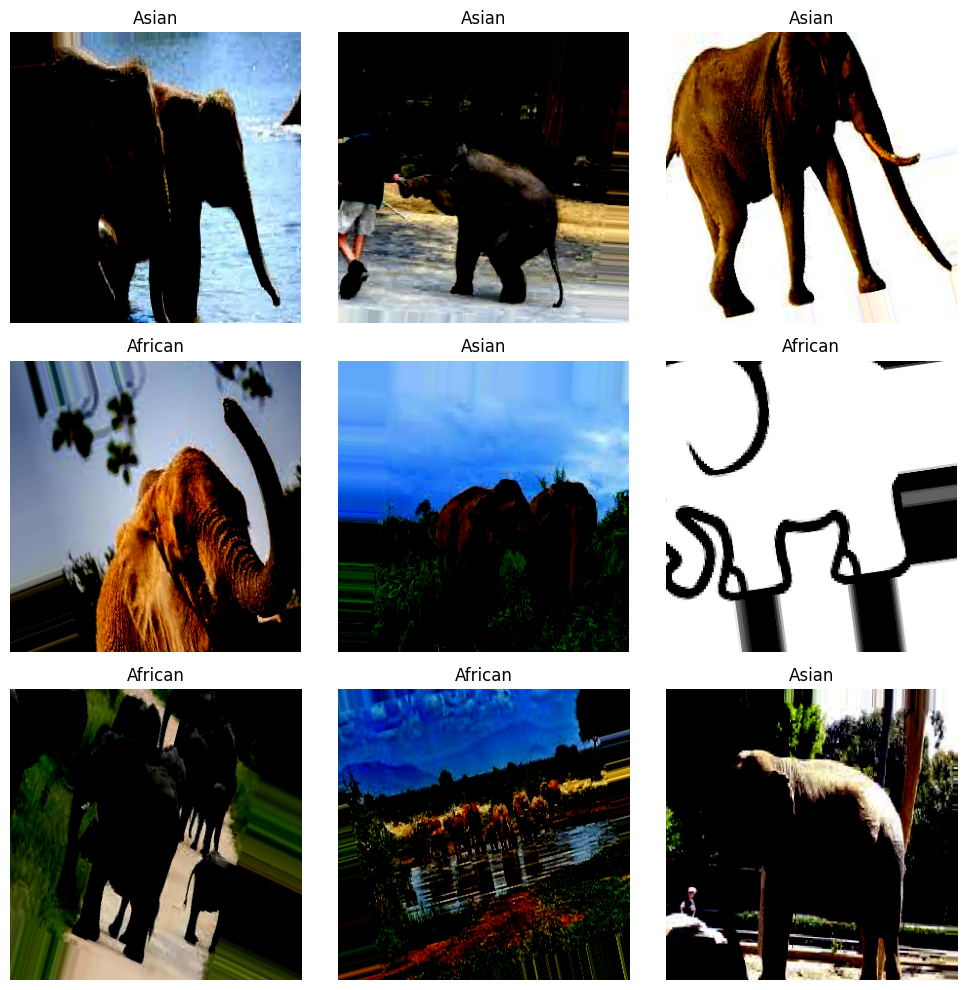

In [ ]:
# Visualize training images
class_names = list(train_data_gen.class_indices.keys())

plt.figure(figsize=(10, 10))
for images, labels in train_data_gen:
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label = class_names[int(labels[i])]
        plt.title(label)
        plt.axis("off")
    break
plt.tight_layout()
plt.show()


Visualize of Misclassified Images

In [ ]:
def visualize_misclassifications(model, val_data_gen):
    val_data_gen.reset()
    predictions = model.predict(val_data_gen)
    predicted_classes = np.round(predictions).astype(int).reshape(-1)
    true_classes = val_data_gen.classes
    class_labels = list(val_data_gen.class_indices.keys())

    errors = np.where(predicted_classes != true_classes)[0]
    print(f"Found {len(errors)} misclassified images out of {len(true_classes)}")

    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(errors[:9]):
        img_path = val_data_gen.filepaths[idx]
        img = plt.imread(img_path)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_labels[true_classes[idx]]}\nPred: {class_labels[predicted_classes[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 857ms/step
Found 25 misclassified images out of 188


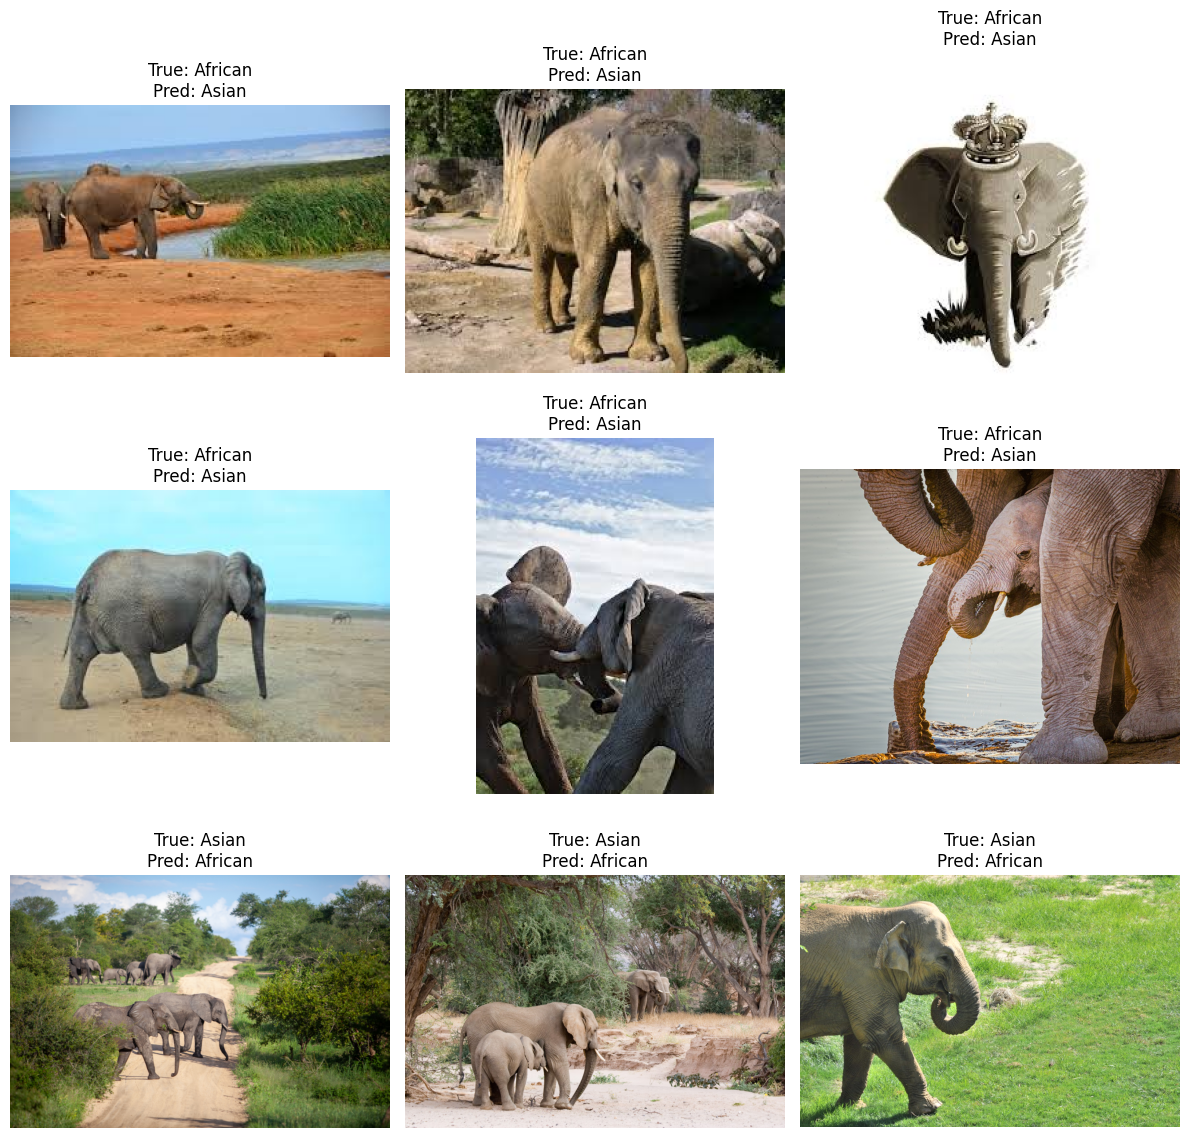

In [ ]:
# See misclassified images
visualize_misclassifications(model, test_data_gen)

In [ ]:
import pandas as pd

df = pd.read_parquet("hf://datasets/bilalRahib/fiqa-personal-finance-dataset/data/train-00000-of-00001.parquet")

df.to_csv("Finance_Questions.csv", index=False)
